In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
import sklearn.cluster as cluster
import time


In [2]:
test2 = pd.read_csv("test2.csv", header = 1, skiprows = 0) # took about 1 minute on my desktop at Emma

In [ ]:
test2

Identify columns to retain

In [ ]:
list(test2.columns.values)

In [ ]:
sns.scatterplot(data=test2, x="Mg", y="Mg.1")
plt.show()

In [ ]:
sns.displot(test2, x="Mg.1", y="Fe.1")
plt.show()

In [ ]:
sns.displot(test2, x="Mg.1", y="Al.1")
plt.show()

In [ ]:
sns.displot(test2, x="Mg.1", y="Si.1")
plt.show()

In [ ]:
sns.displot(test2, x="Mg.1", y="Ca.1")
plt.show()

In [ ]:
sns.displot(test2, x="Ca.1", y="Na.1")
plt.show()

In [ ]:
sns.displot(test2, x="Cu.1", y="S.1")
plt.show()

In [ ]:
sns.displot(test2, x="Cr.1", y="Al.1")
plt.show()

First, try plot without converting to image

In [ ]:
sns.scatterplot(data =test2, x='X', y='Y', hue = "Mg.1")
plt.show()

In [ ]:
sns.displot(data =test2, x='Mg.1', kind="kde")
plt.show()

In [ ]:
sns.displot(data =test2, x='Al.1', kind="kde")
plt.show()

In [ ]:
sns.displot(data =test2, x='Ca.1', kind="kde")
plt.show()

In [ ]:
sns.displot(test2, x="Ca.1", y="Al.1", kind = "kde")
plt.show()

In [ ]:
sns.displot(test2, x="Mg.1", y="O.1")
plt.show()

# Selection of elements for further exploration

Start by just taking in major elements in the major phases - Si, Mg, O, Fe, Al, Ca, Na. 

# How to do phase separation?

Lets try to use a clustering algorithm from scikit learn. 

- Gaussian Mixture Modelling?
- OPTICS?
- DBSCAN?



In [ ]:
df = test2[["Si.1","O.1","Mg.1","Fe.1","Al.1","Ca.1","Na.1"]]

In [38]:
dfm = test2[["Mg.1","Fe.1","Al.1","Ca.1"]] # even smaller table
dfm_s = dfm.sample(n=200000) # subsampled

In [39]:
hdb = hdbscan.HDBSCAN(min_samples=1000).fit(dfm_s)
#core_samples_mask = np.zeros_like(hdb.labels_, dtype=bool)
#core_samples_mask[hdb.core_sample_indices_] = True
labels = hdb.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

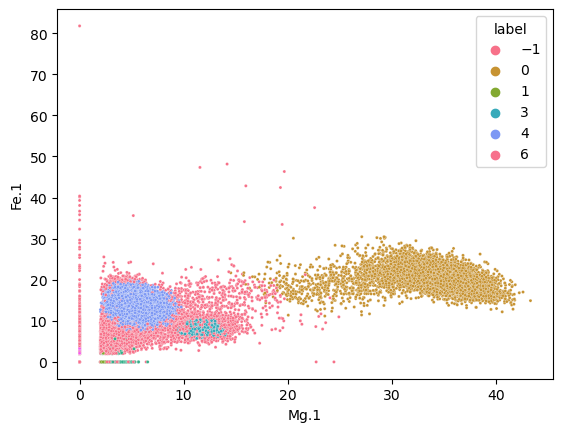

In [44]:
dfm_sl = dfm_s
dfm_sl['label'] = hdb.labels_.tolist()
sns.scatterplot(data = dfm_sl, x="Mg.1", y="Fe.1", hue = "label", palette = "husl", s=5)
plt.show()

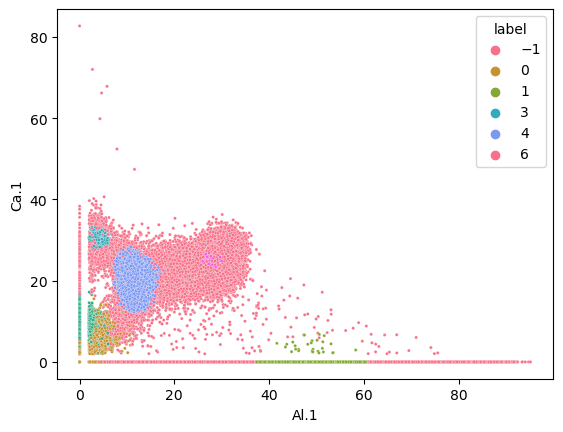

In [45]:
sns.scatterplot(data = dfm_sl, x="Al.1", y="Ca.1", hue = "label", palette = "husl", s=5)
plt.show()

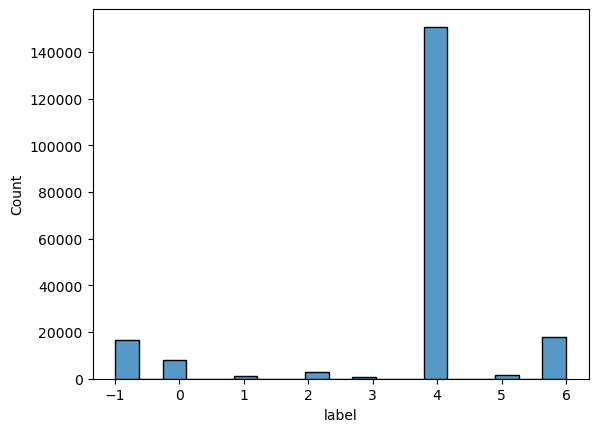

In [42]:
sns.histplot(data=dfm_sl, x="label")
plt.show()

# OK TO HERE

- Experiment with sample size and minimum size for cluster. 

In [11]:
plot_clusters(dfm_s, hdbscan.HDBSCAN, (), {'min_cluster_size':100})

KeyError: 0

In [ ]:
df_sub = df.sample(n=10000)

In [ ]:
sns.displot(df_sub, x="Mg.1", y="Fe.1")
plt.show()

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan


In [ ]:
clust = OPTICS(cluster_method='dbscan')
# clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)
#
# Run the fit
clust.fit(df_sub)

In [ ]:
clust.labels_

In [ ]:
df_sub['class'] = clust.labels_.tolist()

In [ ]:
df_sub

In [ ]:
sns.displot(df_sub, x="Mg.1", y="Fe.1", hue = "class")
plt.show()

In [ ]:
sns.histplot(data=df_sub, x="class")
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

df_sub2 = df.sample(n=10000)

# Compute DBSCAN
db = DBSCAN(eps=6.0, min_samples=100).fit(df_sub2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_sub2, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_sub2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df_sub2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
db.labels_

In [ ]:
df_sub2['class'] = db.labels_.tolist()

In [ ]:
sns.displot(df_sub2, x="Mg.1", y="Fe.1", hue = "class")
plt.show()

In [ ]:
sns.histplot(data=df_sub2, x="class")
plt.show()